In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from jupyterthemes import jtplot
jtplot.style(grid=False)

%matplotlib inline

from env import host, user, password

Use DBSCAN to detect anomalies in other products from the customers dataset.

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("mall_customers")

sql = """
select *
from customers;
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
df = df[['age','annual_income','spending_score']]

np_array = df.values.astype('float32',copy=False)
np_array[0:10]

array([[19., 15., 39.],
       [21., 15., 81.],
       [20., 16.,  6.],
       [23., 16., 77.],
       [31., 17., 40.],
       [22., 17., 76.],
       [35., 18.,  6.],
       [23., 18., 94.],
       [64., 19.,  3.],
       [30., 19., 72.]], dtype=float32)

In [5]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.01923078, 0.        , 0.3877551 ],
       [0.05769232, 0.        , 0.8163265 ],
       [0.03846154, 0.00819672, 0.05102041],
       [0.09615386, 0.00819672, 0.7755102 ],
       [0.25      , 0.01639345, 0.39795917],
       [0.07692307, 0.01639345, 0.7653061 ],
       [0.32692307, 0.02459016, 0.05102041],
       [0.09615386, 0.02459016, 0.94897956],
       [0.8846154 , 0.03278688, 0.02040816],
       [0.23076922, 0.03278688, 0.7244898 ]], dtype=float32)

In [6]:
dbsc = DBSCAN(eps = .20, min_samples = 22).fit(np_array)

In [7]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]


In [8]:
# Save a copy of the original dataframe
original_df = df.copy()

In [9]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [10]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [11]:
labels = dbsc.labels_
labels[0:10]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [12]:
df['labels'] = labels
df.labels.value_counts()

-1    78
 0    56
 2    34
 1    32
Name: labels, dtype: int64

In [13]:
df[df.labels==-1].head()

,age,annual_income,spending_score,Scaled_age,Scaled_annual_income,Scaled_spending_score,labels
0,19,15,39,0.019231,0.000000,0.387755,-1
1,21,15,81,0.057692,0.000000,0.816326,-1
2,20,16,6,0.038462,0.008197,0.051020,-1
3,23,16,77,0.096154,0.008197,0.775510,-1
4,31,17,40,0.250000,0.016393,0.397959,-1


In [14]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
              age  annual_income  spending_score  Scaled_age  \
count  200.000000     200.000000      200.000000  200.000000   
mean    38.850000      60.560000       50.200000    0.400962   
std     13.969007      26.264721       25.823522    0.268635   
min     18.000000      15.000000        1.000000    0.000000   
25%     28.750000      41.500000       34.750000    0.206731   
50%     36.000000      61.500000       50.000000    0.346154   
75%     49.000000      78.000000       73.000000    0.596154   
max     70.000000     137.000000       99.000000    1.000000   

       Scaled_annual_income  Scaled_spending_score      labels  
count            200.000000             200.000000  200.000000  
mean               0.373443               0.502041    0.110000  
std                0.215285               0.263505    1.106354  
min                0.000000               0.000000   -1.000000  
25%                0.217213               0.344388   -1.000000  
50%                0.3

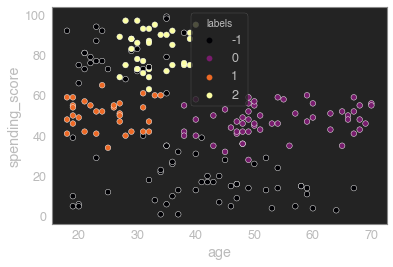

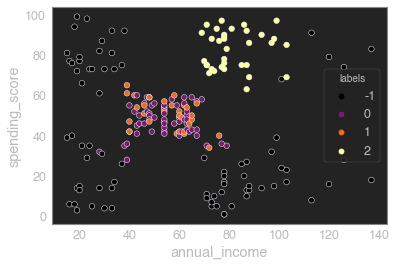

In [15]:
sns.scatterplot(df.age, df.spending_score, hue=df.labels, palette='inferno')
plt.show()

sns.scatterplot(df.annual_income, df.spending_score, hue=df.labels, palette='inferno')
plt.show()

Text(0.5, 0, 'spending_score')

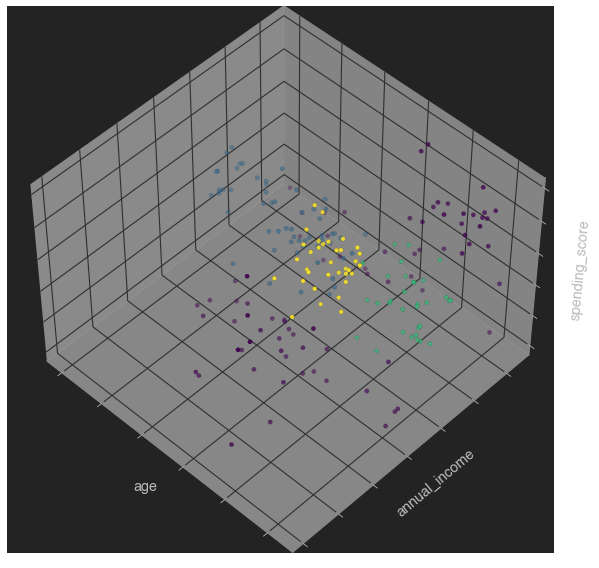

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.age, df.annual_income, df.spending_score,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('age')
ax.set_ylabel('annual_income')
ax.set_zlabel('spending_score')

In [17]:
from wrangle_zillow import wrangle_zillow

In [18]:
df = wrangle_zillow()

In [19]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
df.head()

,parcelid,logerror,transactiondate,bathrooms,bedrooms,buildingqualitytypeid,square_feet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxes,heatingorsystemdesc,county,logerror_absolute,age_in_years,Bathrooms_cat,Bedrooms_cat,tax_rate
0,14297519,0.025595,2017-01-01,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,None,Orange,0.025595,23.0,3.5,4+,1.08
1,17052889,0.055619,2017-01-01,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,None,Ventura,0.055619,54.0,1,2,1.22
2,14186244,0.005383,2017-01-01,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,None,Orange,0.005383,59.0,2,3,1.15
3,12177905,-0.103410,2017-01-01,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,Central,Los_Angeles,0.103410,51.0,3,4+,1.22
4,10887214,0.006940,2017-01-01,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,12447.0,3101.0,96451.0,0.0,1.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,Central,Los_Angeles,0.006940,57.0,3,3,1.28


In [20]:
df = df[['square_feet','bedrooms','tax_value']]
df.head()

,square_feet,bedrooms,tax_value
0,3100.0,4.0,1023282.0
1,1465.0,2.0,464000.0
2,1243.0,3.0,564778.0
3,2376.0,4.0,145143.0
4,1312.0,3.0,119407.0


In [21]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[3.100000e+03, 4.000000e+00, 1.023282e+06],
       [1.465000e+03, 2.000000e+00, 4.640000e+05],
       [1.243000e+03, 3.000000e+00, 5.647780e+05],
       [2.376000e+03, 4.000000e+00, 1.451430e+05],
       [1.312000e+03, 3.000000e+00, 1.194070e+05],
       [1.492000e+03, 3.000000e+00, 3.310640e+05],
       [2.962000e+03, 4.000000e+00, 7.733030e+05],
       [7.380000e+02, 2.000000e+00, 2.185520e+05],
       [3.039000e+03, 4.000000e+00, 2.205830e+05],
       [1.290000e+03, 2.000000e+00, 3.713610e+05]], dtype=float32)

In [22]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.3600526 , 0.3       , 0.9229795 ],
       [0.14520368, 0.1       , 0.41690925],
       [0.11603154, 0.20000002, 0.5080989 ],
       [0.2649146 , 0.3       , 0.12838925],
       [0.12509856, 0.20000002, 0.10510186],
       [0.14875165, 0.20000002, 0.29662117],
       [0.34191853, 0.3       , 0.69678426],
       [0.04967149, 0.1       , 0.1948139 ],
       [0.3520368 , 0.3       , 0.19665167],
       [0.12220763, 0.1       , 0.3330842 ]], dtype=float32)

In [23]:
dbsc = DBSCAN(eps = .20, min_samples = 25).fit(np_array)

In [24]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [25]:
# Save a copy of the original dataframe
original_df = df.copy()

In [26]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [27]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [28]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
df['labels'] = labels
df.labels.value_counts()

 0    66846
-1       12
Name: labels, dtype: int64

In [30]:
df[df.labels==-1].head()

,square_feet,bedrooms,tax_value,Scaled_square_feet,Scaled_bedrooms,Scaled_tax_value,labels
8438,4670.0,9.0,638499.0,0.566360,0.8,0.574806,-1
9033,7456.0,8.0,791000.0,0.932457,0.7,0.712797,-1
9920,7970.0,9.0,460294.0,1.000000,0.8,0.413556,-1
12540,7524.0,8.0,504282.0,0.941393,0.7,0.453359,-1
17476,2892.0,9.0,662000.0,0.332720,0.8,0.596071,-1


In [31]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
        square_feet      bedrooms     tax_value  Scaled_square_feet  \
count  66858.000000  66858.000000  6.685800e+04        66858.000000   
mean    1627.752236      2.957193  3.761433e+05            0.166591   
std      688.561938      0.961402  2.359160e+05            0.090481   
min      360.000000      1.000000  3.254000e+03            0.000000   
25%     1150.000000      2.000000  1.952375e+05            0.103811   
50%     1472.000000      3.000000  3.373050e+05            0.146124   
75%     1941.000000      4.000000  5.097140e+05            0.207753   
max     7970.000000     11.000000  1.108401e+06            1.000000   

       Scaled_bedrooms  Scaled_tax_value        labels  
count     66858.000000      66858.000000  66858.000000  
mean          0.195721          0.337411     -0.000179  
std           0.096129          0.213470      0.013396  
min           0.000000          0.000000     -1.000000  
25%           0.100000          0.173718      0.000000  
50%    

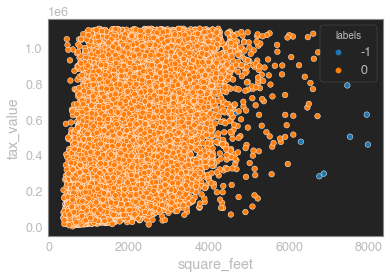

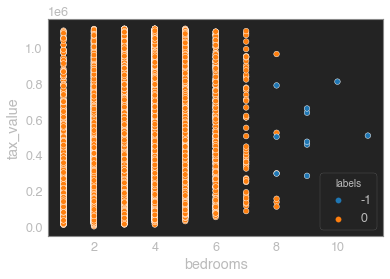

In [32]:
sns.scatterplot(df.square_feet, df.tax_value, hue=df.labels, palette='tab10')
plt.show()

sns.scatterplot(df.bedrooms, df.tax_value, hue=df.labels, palette='tab10')
plt.show()

Text(0.5, 0, 'tax_value')

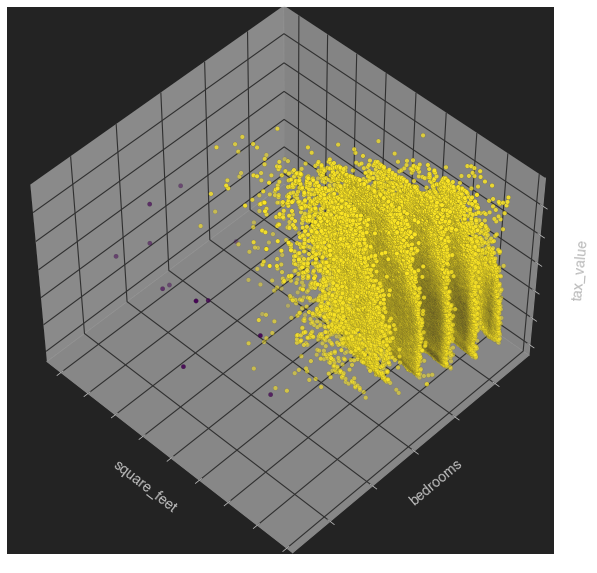

In [33]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.square_feet, df.bedrooms, df.tax_value,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('square_feet')
ax.set_ylabel('bedrooms')
ax.set_zlabel('tax_value')